# The Effect of Languages on Movies: The Multi-Faceted Story of a Single Parameter

## Data Preprocessing Pipeline
- Clean up the prefix and suffix of some columns
- Overview of data information, e.g. data type, missing data
- Combine Mojo dataset with the original data to improve the situation with a lot of missing revenue data

In [157]:
import numpy as np
import pandas as pd
import re
import ast
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import statsmodels.formula.api as smf
from matplotlib.ticker import FuncFormatter
warnings.filterwarnings('ignore')

In [158]:
# Change the file path for the file movie.metadata.tsv
file_path = "data/movie.metadata.tsv"

In [159]:
# Reading the file into a pandas dataframe
movie_summaries = pd.read_csv(file_path, sep="\t", header=None)
movie_summaries.columns = ["Wikipedia movie ID",
 "Freebase_movie_ID",
 "Movie_name",
 "Movie_release_date",
 "Movie_box_office_revenue",
 "Movie_runtime",
 "Movie_languages",
 "Movie_countries",
 "Movie_genres"]
movie_summaries.head()

,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [160]:
# Remove prefix '/m/'
movie_summaries['Freebase_movie_ID'] = movie_summaries['Freebase_movie_ID'].str.replace('/m/', '')

In [161]:
# Create new columns for languages, countries and genres
# The data type of the new columns is list containing all possible values
# Only take the values into account for now,
# If we need the code for further analysis, just apply x.keys() instead of x.values()

movie_summaries['Movie_languages_clean'] = movie_summaries['Movie_languages'].apply(ast.literal_eval).apply(lambda x: list(x.values()))
movie_summaries['Movie_countries_clean'] = movie_summaries['Movie_countries'].apply(ast.literal_eval).apply(lambda x: list(x.values()))
movie_summaries['Movie_genres_clean'] = movie_summaries['Movie_genres'].apply(ast.literal_eval).apply(lambda x: list(x.values()))

In [162]:
# Extract the release year
# This column only contains the years
movie_summaries['Movie_release_year'] = movie_summaries['Movie_release_date'].str.extract(r'(\d{4})')

# Convert strings to datetime values if there are
# For the rows with only years, the value is replaced by NaT
# pd.to_datetime has a bug if the format provided is more "precise" than what is in the dataframe, it has default values and will not
# raise an error or replace with NaT
# specifically %Y-%m-%d with year 2000 defaults to 2000-01-01, even with the exact=True argument.
movie_summaries['Movie_release_date_datetime'] = movie_summaries['Movie_release_date'].astype('str').apply(
        lambda x: pd.to_datetime(x if "-" in x else pd.NaT, errors="coerce")
)

In [163]:
movie_summaries.head()

,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Movie_languages_clean,Movie_countries_clean,Movie_genres_clean,Movie_release_year,Movie_release_date_datetime
0,975900,03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,2001-08-24
1,3196793,08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",2000,2000-02-16
2,28463795,0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",[Norwegian Language],[Norway],"[Crime Fiction, Drama]",1988,NaT
3,9363483,0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",1987,NaT
4,261236,01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",[German Language],[Germany],[Drama],1983,NaT


In [164]:
# Add mojo box office dataset
import requests
from bs4 import BeautifulSoup

In [165]:
def getData(year):
    url = f'https://www.boxofficemojo.com/year/{year}/?sortDir=asc&sort=rank&grossesOption=totalGrosses'

    # Send a GET request to the URL
    response = requests.get(url)

    df = pd.DataFrame()
    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Parse the HTML content of the page
        soup = BeautifulSoup(response.content, 'html.parser')

        # Extract relevant information (modify this based on the structure of the webpage)
        # Example: Extracting movie titles
        df['movie_title'] = [title.text.strip() for title in soup.find_all('td', class_='a-text-left mojo-field-type-release mojo-cell-wide')]
        df['movie_revenue'] = [title.text.strip() for title in soup.find_all('td', class_='a-text-right mojo-field-type-money mojo-estimatable')]


    return df

In [166]:
# Reading the file into a pandas dataframe
df_all = pd.read_csv('mojo_data.csv', header=None)
df_all.columns = ["movie_title", "movie_revenue"]
df_all.head()

,movie_title,movie_revenue
0,Star Wars: Episode IV - A New Hope,"$307,263,857"
1,Smokey and the Bandit,"$126,737,428"
2,Close Encounters of the Third Kind,"$116,395,460"
3,Saturday Night Fever,"$94,213,184"
4,A Bridge Too Far,"$50,750,000"


In [167]:
# We can just always consider the original dataset, and replace the missing revenues with the ones from the Mojo dateset

# Drop duplicate movies, based on name only
df_all = df_all.drop_duplicates(subset=['movie_title'])
movie_summaries = movie_summaries.drop_duplicates(subset=['Movie_name'])
# Merge dataframes based on the movie name, left join so we keep all of the original data
merged_df = pd.merge(movie_summaries, df_all, right_on='movie_title', left_on='Movie_name', how='left')

# Drop the extra column (either 'movie_title' or 'Movie_name') if needed
# merged_df = merged_df.drop('movie_title', axis=1)

# Cleaning up the revenues

# Remove the dollar sign and commas
merged_df['movie_revenue'] = merged_df['movie_revenue'].astype(str).str.replace('$', '').str.replace(',', '')

# Convert the column to floats
merged_df['movie_revenue'] = merged_df['movie_revenue'].astype(float)

# Create a boolean mask for rows where movie_revenue is NaN and gross_revenue is not NaN
mask = (pd.isna(merged_df['Movie_box_office_revenue'])) & (~pd.isna(merged_df['movie_revenue']))

# Replace missing values in Movie_box_office_revenue with movie_revenue
merged_df.loc[mask, 'Movie_box_office_revenue'] = merged_df.loc[mask, 'movie_revenue']

In [168]:
#Adding the Budget dataset

In [169]:
budget_path= "https://drive.google.com/uc?id=" + "https://drive.google.com/file/d/1P6utrC8Hjxh4HJ3q8GQZwXMOmDmhwFzS/view?usp=sharing".split("/")[-2]

budget = pd.read_csv(
    budget_path, usecols=["id", "budget", "original_title", "release_date", "runtime"]
)

#Conversion to datetime
budget["Movie_release_year"] = pd.to_datetime(
    budget["release_date"], infer_datetime_format=True, errors="coerce"
).dt.year

#renaming for column matching in the merge
budget = budget.rename(
    columns={"original_title": "Movie_name", "runtime": "Movie_runtime"}
)

# converting '\\N' values to np.nan
budget.loc[budget["Movie_release_year"] == "\\N", "Movie_release_year"] = np.nan
budget.loc[budget["Movie_runtime"] == "\\N", "Movie_runtime"] = np.nan

#removing the rows with nan
budget = budget[budget["Movie_release_year"].notna()]

# converting release year to 'int64'
budget["Movie_release_year"] = budget["Movie_release_year"].astype("int64", errors="ignore")

# converting runtime to 'float64'
budget["Movie_runtime"] = budget["Movie_runtime"].astype("float64")

In [170]:
#Merging the budget datafram with the main dataframe
budget["Movie_release_year"] = budget["Movie_release_year"].astype("str")
# merge 'movies' with 'budget'
merged_df = pd.merge(
    left=merged_df,
    right=budget,
    how="left",
    on=["Movie_name", "Movie_release_year", "Movie_runtime"],
)
# convert budget to float
merged_df["budget"] = merged_df["budget"].astype("float")

merged_df.head()

,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Movie_languages_clean,Movie_countries_clean,Movie_genres_clean,Movie_release_year,Movie_release_date_datetime,movie_title,movie_revenue,budget,id,release_date
0,975900,03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,2001-08-24,Ghosts of Mars,8709640.0,28000000.0,10016,2001-08-24
1,3196793,08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",2000,2000-02-16,NaN,NaN,NaN,NaN,NaN
2,28463795,0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",[Norwegian Language],[Norway],"[Crime Fiction, Drama]",1988,NaT,NaN,NaN,NaN,NaN,NaN
3,9363483,0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",1987,NaT,NaN,NaN,NaN,NaN,NaN
4,261236,01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",[German Language],[Germany],[Drama],1983,NaT,NaN,NaN,NaN,NaN,NaN


In [171]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75481 entries, 0 to 75480
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Wikipedia movie ID           75481 non-null  int64         
 1   Freebase_movie_ID            75481 non-null  object        
 2   Movie_name                   75481 non-null  object        
 3   Movie_release_date           68981 non-null  object        
 4   Movie_box_office_revenue     9378 non-null   float64       
 5   Movie_runtime                56348 non-null  float64       
 6   Movie_languages              75481 non-null  object        
 7   Movie_countries              75481 non-null  object        
 8   Movie_genres                 75481 non-null  object        
 9   Movie_languages_clean        75481 non-null  object        
 10  Movie_countries_clean        75481 non-null  object        
 11  Movie_genres_clean           75481 non-nu

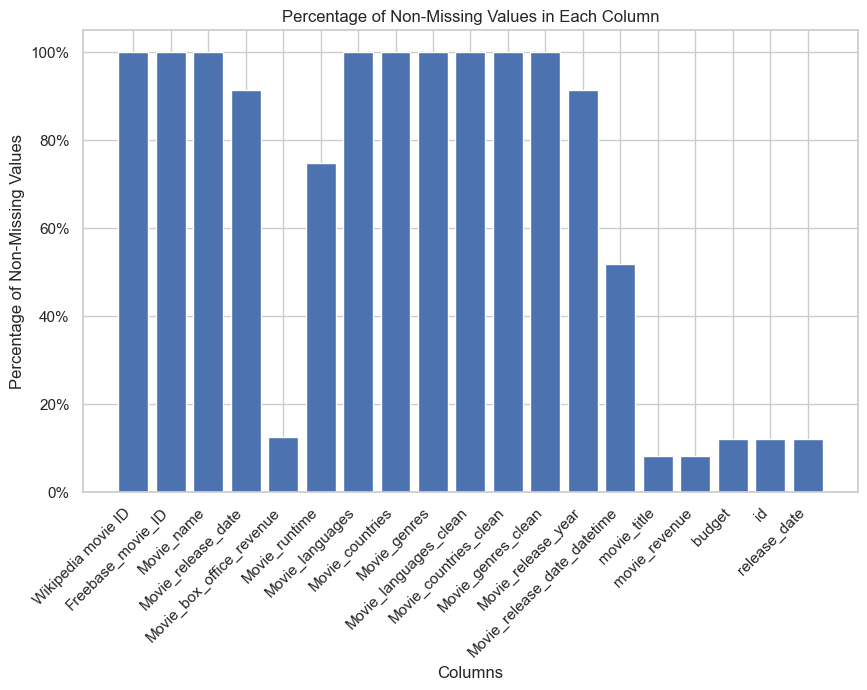

In [172]:
# Calculate the percentage of non-missing values for each column
percentage_non_missing = (merged_df.count() / len(merged_df)) * 100

# Plot the results
plt.figure(figsize=(10,6))
plt.bar(percentage_non_missing.index, percentage_non_missing)
plt.xlabel('Columns')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Percentage of Non-Missing Values')
plt.title('Percentage of Non-Missing Values in Each Column')

def percent_formatter(x, pos):
    return f'{x:.0f}%'

plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_formatter))
plt.show()

In [173]:
print("Movie merged with budget shape", movie_summaries.shape)

Movie merged with budget shape (75478, 14)


## Q1: Does language variety mean more box office revenue?
The purpose of this section is to investigate the possible correlation between the box office revenue and the number of languages presented in a movie. First, we determine the length of the language list, assigning a value of zero if the list is empty. In addition, we eliminate all NaN values, especially given our initial investigation which revealed a considerable amount of missing data in the movie revenue. At the end, we have in total 8401 useful entries to analyse.

In [174]:
# Count the number of languages in a movie
# Create a new column
df = merged_df.copy(deep=True)
df.info()
df['language_count'] = df['Movie_languages_clean'].apply(len)
df_language_count = df[['Movie_name', 'Movie_box_office_revenue', 'language_count']].dropna()
df_language_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75481 entries, 0 to 75480
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Wikipedia movie ID           75481 non-null  int64         
 1   Freebase_movie_ID            75481 non-null  object        
 2   Movie_name                   75481 non-null  object        
 3   Movie_release_date           68981 non-null  object        
 4   Movie_box_office_revenue     9378 non-null   float64       
 5   Movie_runtime                56348 non-null  float64       
 6   Movie_languages              75481 non-null  object        
 7   Movie_countries              75481 non-null  object        
 8   Movie_genres                 75481 non-null  object        
 9   Movie_languages_clean        75481 non-null  object        
 10  Movie_countries_clean        75481 non-null  object        
 11  Movie_genres_clean           75481 non-nu

#### Language Count Distribution
We focus on the number of languages and try to understand the distribution of languages. The plot shows that the majority of films (76.56% of non-NaN data in box office revenue) have only one language. This presents a challenge for further analysis as it indicates a significant imbalance in the data set when examining language diversity.

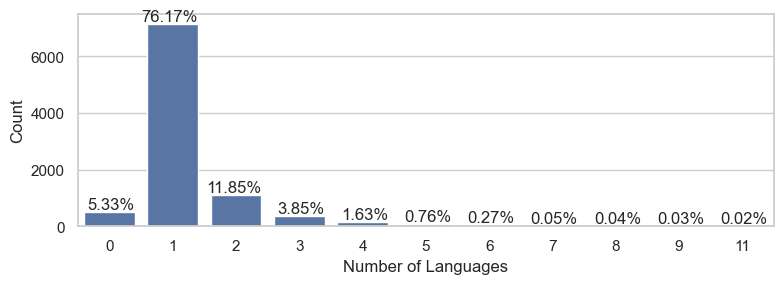

In [175]:
plt.figure(figsize=(8,3))
ax = sns.countplot(df_language_count, x='language_count')
ax.set(xlabel='Number of Languages', ylabel='Count')
for p in ax.patches:
    percentage = '{:.2f}%'.format(100 * p.get_height()/float(len(df_language_count)))
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='right', va='bottom')

plt.tight_layout()

#### Box Office Revenue Distribution
The box office revenue data have some extreme values. To improve the clarity and interpretability of the distribution in our visualizations, we use a logarithmic scale.

Text(0.5, 0, 'Box Office Revenue\n(Log Scale)')

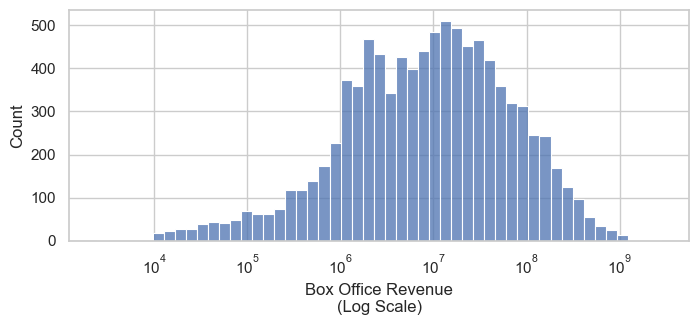

In [176]:
plt.figure(figsize=(8,3))
sns.histplot(df_language_count, x='Movie_box_office_revenue', log_scale=True)
plt.xlabel('Box Office Revenue\n(Log Scale)')

#### Box Office Revenue v.s. Number of Languages
We want to examine the correlation between these two variables. While this visualization suggests a trend towards higher box office results for more languages, it is important to note that the comparison may not be meaningful due to unequal data sizes across language groups.

Text(0, 0.5, 'Box Office Revenue\n(Log Scale)')

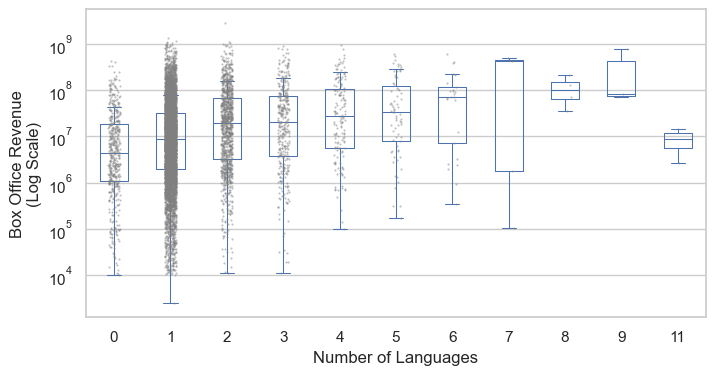

In [177]:
plt.figure(figsize=(8, 4))
sns.boxplot(df_language_count, y='Movie_box_office_revenue', x='language_count', fill=False, width=.5, linewidth=.75, showfliers=False)
sns.stripplot(df_language_count, y='Movie_box_office_revenue', x='language_count', size=1.5, log_scale=True, color='grey', alpha=0.5)
plt.xlabel('Number of Languages')
plt.ylabel('Box Office Revenue\n(Log Scale)')

### Correlation and Test
So, for the correlation, we formulate the following hypothesis test:
- **Null Hypothesis (H0):** There is no correlation between the number of languages and box revenue.
- **Alternative Hypothesis (H1):** There is a correlation between the number of languages and box revenue.

We select a significance level of 0.05. The calculation of the correlation coefficient and the associated p-value provides further information on the relationship between box office receipts and the number of languages. The calculated p-value is smaller than the selected significance level, so that we can reject the null hypothesis. This indicates a statistically significant correlation between the number of languages and box office takings. However, given the unbalanced data set, further tests or data transformations should be performed to confirm this result.

In [178]:
from scipy.stats import pearsonr

correlation_coefficient, p_value = pearsonr(df_language_count['language_count'], df_language_count['Movie_box_office_revenue'])
print(f"R: {correlation_coefficient}\nP-value: {p_value}")

R: 0.15690609610054831
P-value: 9.256586468037208e-53


### Q1: Sub-section - Budget

Whereas we identified a significant correlation between the number of languages in a movie and its box office revenue, this doesn't establish that having more languages in a movie brings in more revenue. It is also probable that high budget films, made to bring in high revenue, are the types of movies that can have such a language variety. To investigate this, we will analyse any possible correlations between budget data of a movie and its box office revenue and language counts.

In [179]:
budget_df= df[df["budget"].notna() & df["budget"] != 0].copy(deep=True)
budget_df_count = budget_df[['Movie_name', 'Movie_box_office_revenue', 'budget','language_count','Movie_genres_clean']].dropna().copy(deep=True)

Text(0.5, 1.0, 'The Distribution of Movie Budget Sizes')

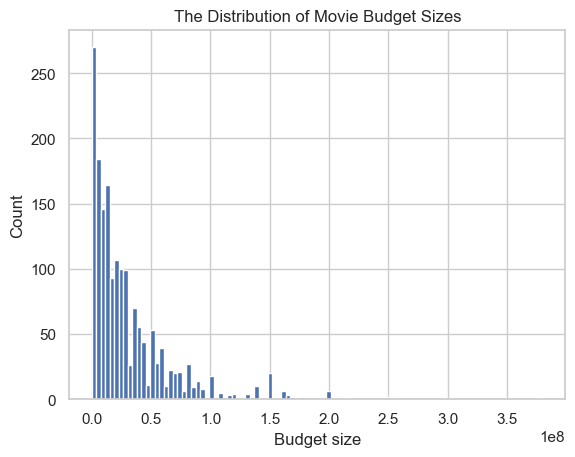

In [180]:
#Distribution plot
budget_df_count["budget"].hist(bins=100)
#plt.xscale("log")
plt.xlabel('Budget size') 
plt.ylabel('Count')
plt.title("The Distribution of Movie Budget Sizes")

#### Budget Size and Revenue

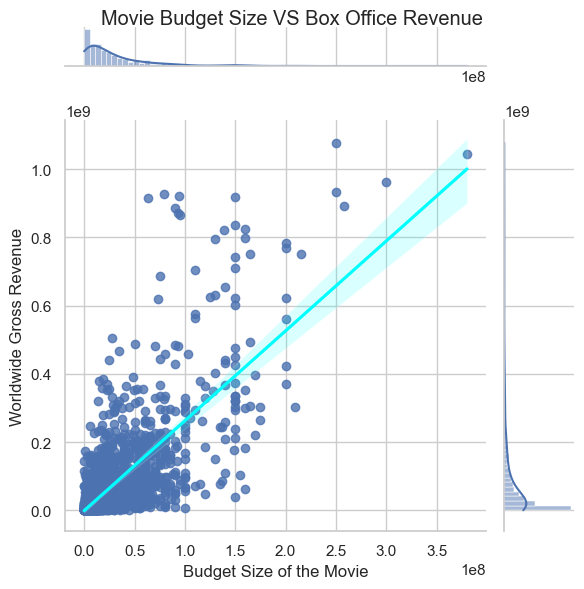

In [181]:
p1 = sns.jointplot(data = budget_df_count, x = "budget", y = 'Movie_box_office_revenue', kind="reg", joint_kws={'line_kws':{'color':'cyan'}})
plt.xlabel("Budget Size of the Movie")
plt.ylabel('Worldwide Gross Revenue')
p1.fig.suptitle("Movie Budget Size VS Box Office Revenue")
p1.fig.tight_layout()
p1.fig.subplots_adjust(top=0.95) # Reduce plot to make room

In [182]:
correlation_coefficient, p_value = pearsonr(budget_df_count['budget'], budget_df_count['Movie_box_office_revenue'])
print(f"R: {correlation_coefficient}\nP-value: {p_value}")

R: 0.7236360726046409
P-value: 1.9070447023180004e-279


Indeed, we see a positive linear trend between the budget of a movie and its box office revenue, with R ~= 0.72. 

#### Budget Size and Language Count

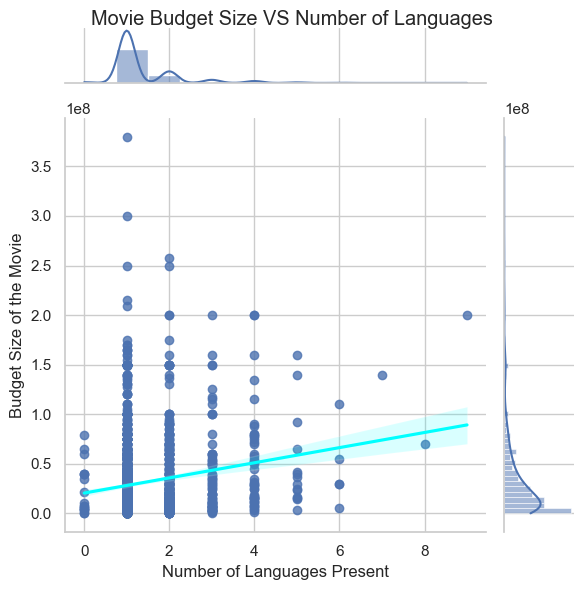

In [183]:
p2= sns.jointplot(data = budget_df_count, x = "language_count", y = 'budget', kind="reg", joint_kws={'line_kws':{'color':'cyan'}})
plt.xlabel('Number of Languages Present')
plt.ylabel("Budget Size of the Movie")
p2.fig.suptitle("Movie Budget Size VS Number of Languages")
p2.fig.tight_layout()
p2.fig.subplots_adjust(top=0.95) # Reduce plot to make room

In [184]:
correlation_coefficient, p_value = pearsonr(budget_df_count['budget'], budget_df_count['language_count'])
print(f"R: {correlation_coefficient}\nP-value: {p_value}")

R: 0.1770352794307683
P-value: 1.343828138835108e-13


Whereas we also see a positive linear trend between the number of languages and the budget size, the correlation is not as strong. Especially in 1-2 language movies (and a bit less so in 3-5 language movies), the budget size per movie varies quite a lot.

#### Take-away
Overall, the budget size of a movie of has a positive linear relationship with both revenue and number of languages. This does put the budget size as a possible confonduer, especially with the significant p-values being observed. More investigation might be required to shop the relationship between these three parameters.

### Matching for Budget and Genre and Testing

As stated above, we identified the budget as a possible covariate. Recognising that the distribution of the genres (further examined in Q4) might also skew our results, we opted to match for these variables. We defined the treatment condition as having more than one language in a movie, and matched a one control movie to one treatment movie, per iteration. We imposed the following conditions for matching:

* The percentage difference in budget between treatment and control movies is below 20%.

* There is at least one common movie genre between the treatment and control movies.


In [185]:
# Separate the treatment and control groups
treatment_df = budget_df_count[budget_df_count['language_count'] > 1]
control_df = budget_df_count[budget_df_count['language_count'] <= 1]

# Create an empty undirected graph
G = nx.Graph()

# Loop through all the pairs of instances
for control_id, control_row in control_df.iterrows():
    for treatment_id, treatment_row in treatment_df.iterrows():

        # Convert genre lists to sets for intersection
        control_genres = set(control_row["Movie_genres_clean"])
        treatment_genres = set(treatment_row["Movie_genres_clean"])

        # Check for at least one common movie genre
        if (
            abs(treatment_row["budget"] - control_row["budget"]) / ((treatment_row["budget"] + control_row["budget"]) / 2) * 100 < 20
            and control_genres.intersection(treatment_genres)
        ):
            G.add_edges_from([(control_id, treatment_id)])

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
balanced_df_budget = budget_df_count.loc[matched]

In [186]:
# Model_matched : Movie_box_office_revenue ~ language_count
model_matched = smf.ols(formula='Movie_box_office_revenue ~ language_count', data=balanced_df_budget).fit()
print("\033[1mModel Matched: Movie_box_office_revenue ~ language_count\033[0m")
print(model_matched.summary())

Model Matched: Movie_box_office_revenue ~ language_count
                               OLS Regression Results                               
Dep. Variable:     Movie_box_office_revenue   R-squared:                       0.008
Model:                                  OLS   Adj. R-squared:                  0.007
Method:                       Least Squares   F-statistic:                     7.114
Date:                      Fri, 22 Dec 2023   Prob (F-statistic):            0.00779
Time:                              13:14:15   Log-Likelihood:                -17346.
No. Observations:                       854   AIC:                         3.470e+04
Df Residuals:                           852   BIC:                         3.471e+04
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------

We observe a a positive coefficient for the language count in the linear regression for its prediction of box office revenue. This relationship is statistically singificant, with a p-value of 0.008 < 0.05. We can consider this as a promising step in establishing a positive relationship between having multiple languages in a movie and having an increased revenue. We do equally note however, that our standard error is relatively high, and therefore it would be pertinent for a future study to perform this test again with a more comprehensive dataset to further elucidate this relationship.

## Q2: Which languages lead to more box office revenue?


### Total revenue per language

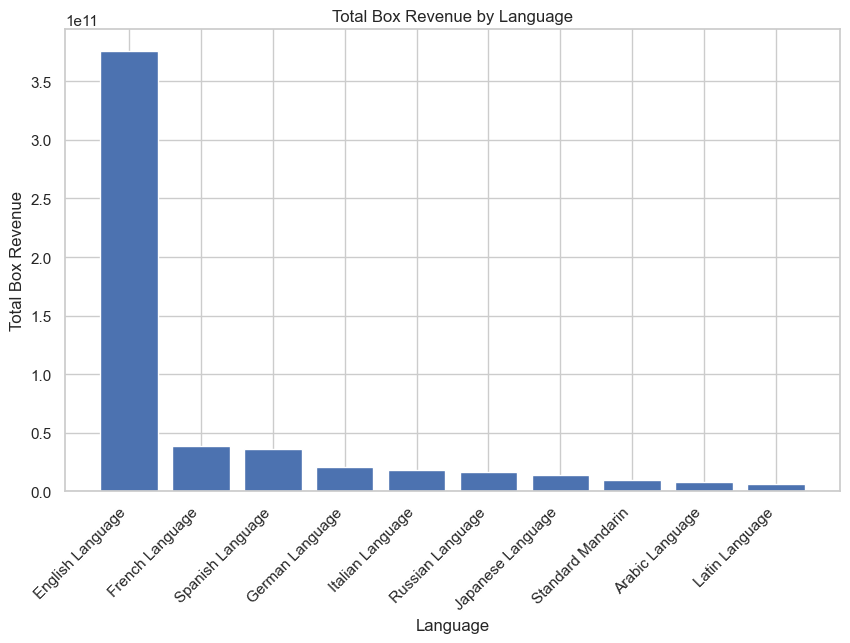

The language that makes the most money is English Language with a total revenue of $375,473,716,080.0


In [187]:
df_language = merged_df[['Freebase_movie_ID', 'Movie_name', 'Movie_box_office_revenue', 'Movie_languages_clean']]
df_language = df_language.explode('Movie_languages_clean')
language_revenue = df_language.groupby('Movie_languages_clean')['Movie_box_office_revenue'].sum().reset_index()
language_revenue = language_revenue.sort_values(by='Movie_box_office_revenue', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(language_revenue['Movie_languages_clean'][:10], language_revenue['Movie_box_office_revenue'][:10])
plt.xlabel('Language')
plt.ylabel('Total Box Revenue')
plt.title('Total Box Revenue by Language')
plt.xticks(rotation=45, ha='right')

plt.show()
language_revenue = language_revenue.sort_values(by='Movie_box_office_revenue', ascending=False)
top_language = language_revenue.iloc[0]['Movie_languages_clean']
top_revenue = language_revenue.iloc[0]['Movie_box_office_revenue']
print(f"The language that makes the most money is {top_language} with a total revenue of ${top_revenue:,}")

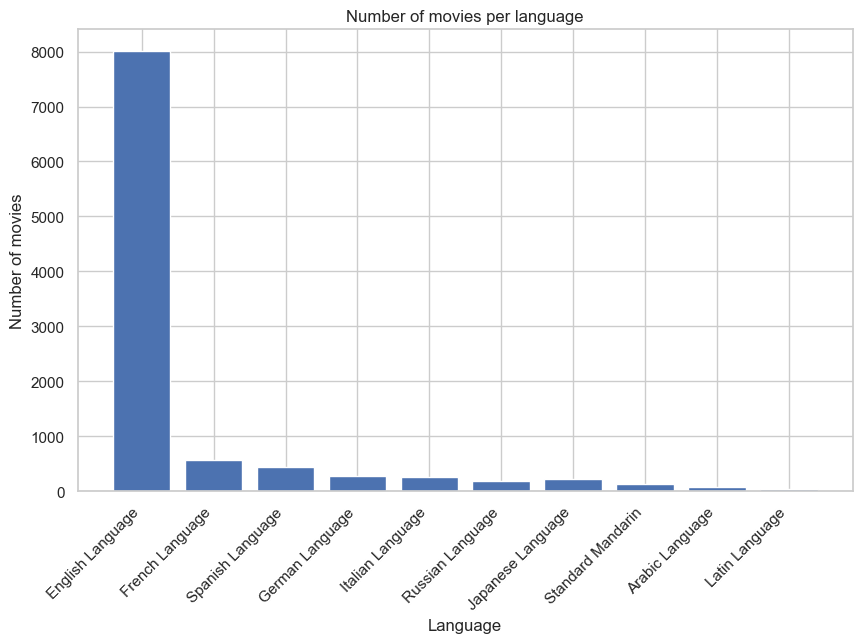

In [188]:
df_language = merged_df[['Freebase_movie_ID', 'Movie_name', 'Movie_box_office_revenue', 'Movie_languages_clean']]
df_language = df_language.explode('Movie_languages_clean')
language_revenue = df_language.groupby('Movie_languages_clean')['Movie_box_office_revenue'].agg(['sum', 'count']).reset_index()
language_revenue = language_revenue.sort_values(by='sum', ascending=False)

# Calculate the average revenue per movie for each language
language_stats = df_language.groupby('Movie_languages_clean')['Movie_box_office_revenue'].agg(['sum', 'count'])
language_stats['average_revenue_per_movie'] = language_stats['sum'] / language_stats['count']
language_stats = language_stats.sort_values(by='average_revenue_per_movie', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(language_revenue['Movie_languages_clean'][:10], language_revenue['count'][:10])
plt.xlabel('Language')
plt.ylabel('Number of movies')
plt.title('Number of movies per language')
plt.xticks(rotation=45, ha='right')

plt.show()


## Average revenue per language

The language with the highest average revenue per movie is Old English language with an average revenue of $747,456,792.33


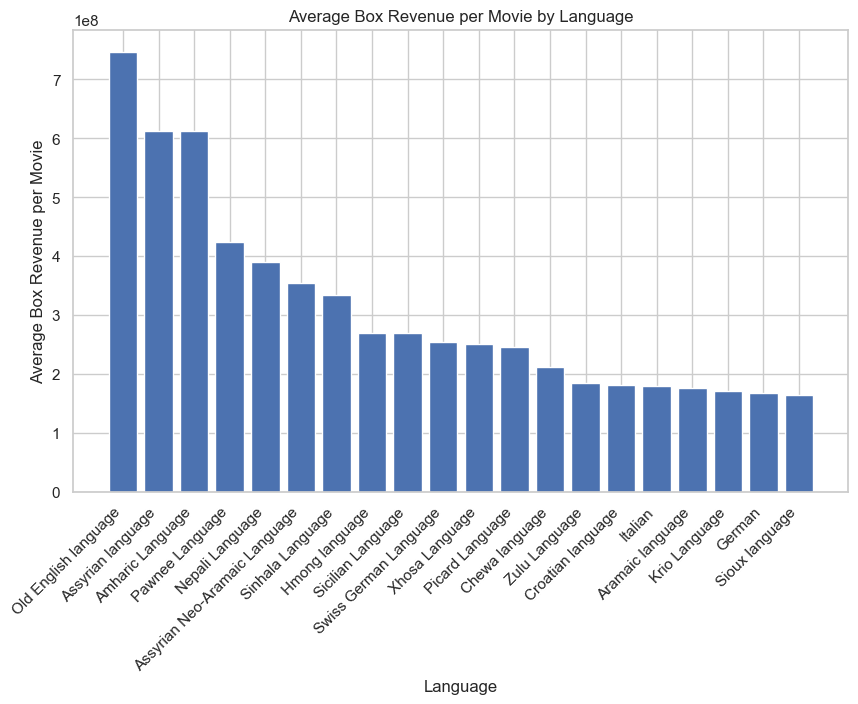

In [189]:
df_language = merged_df[['Freebase_movie_ID', 'Movie_name', 'Movie_box_office_revenue', 'Movie_languages_clean']]
df_language = df_language.explode('Movie_languages_clean')

# Calculate the average revenue per movie for each language
language_stats = df_language.groupby('Movie_languages_clean')['Movie_box_office_revenue'].agg(['sum', 'count'])
language_stats['average_revenue_per_movie'] = language_stats['sum'] / language_stats['count']
language_stats = language_stats.sort_values(by='average_revenue_per_movie', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(language_stats.index[:20], language_stats['average_revenue_per_movie'][:20])
plt.xlabel('Language')
plt.ylabel('Average Box Revenue per Movie')
plt.title('Average Box Revenue per Movie by Language')
plt.xticks(rotation=45, ha='right')


top_language = language_stats.index[0]
top_average_revenue = language_stats['average_revenue_per_movie'].iloc[0]
print(f"The language with the highest average revenue per movie is {top_language} with an average revenue of ${top_average_revenue:,.2f}")


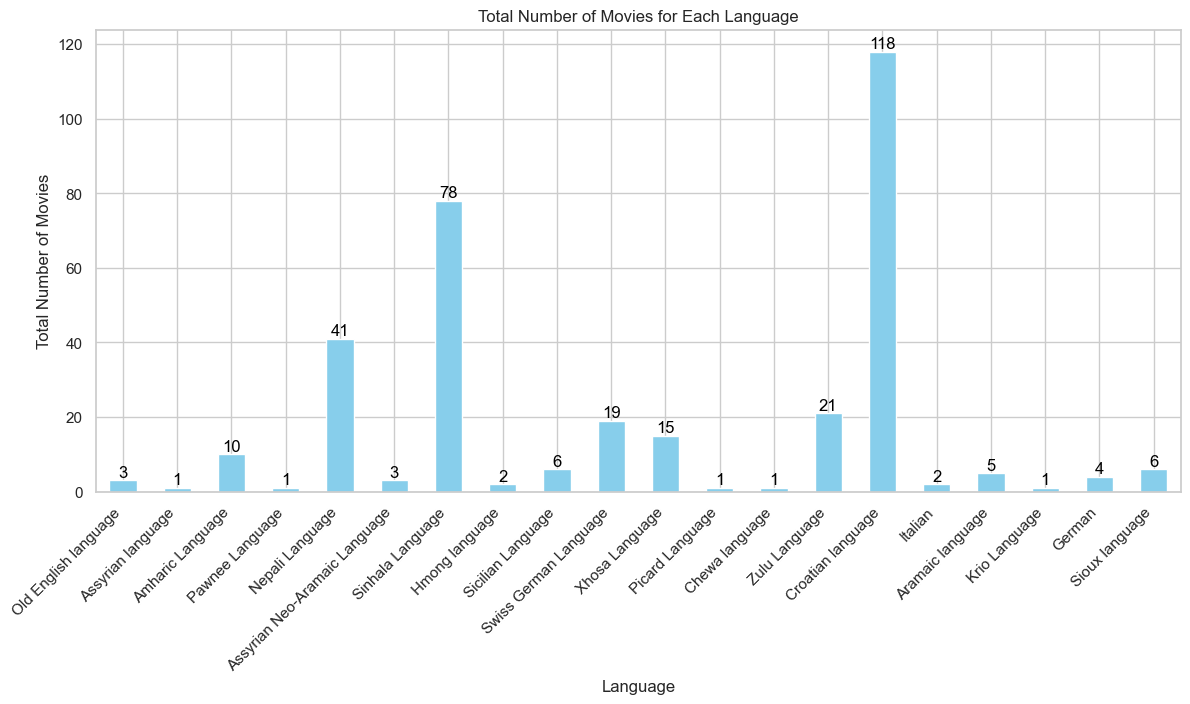

In [190]:
total_movies_per_language = df_language['Movie_languages_clean'].value_counts()

# Languages with the highest revenues
specified_order = ['Old English language', 'Assyrian language', 'Amharic Language',
                   'Pawnee Language', 'Nepali Language', 'Assyrian Neo-Aramaic Language',
                   'Sinhala Language', 'Hmong language', 'Sicilian Language',
                   'Swiss German Language', 'Xhosa Language', 'Picard Language',
                   'Chewa language', 'Zulu Language', 'Croatian language', 'Italian',
                   'Aramaic language', 'Krio Language', 'German', 'Sioux language']

total_movies_per_language = total_movies_per_language.reindex(specified_order, fill_value=0)

# Plotting the bar chart
plt.figure(figsize=(14, 6))
bars = total_movies_per_language.plot(kind='bar', color='skyblue')
plt.title('Total Number of Movies for Each Language')
plt.xlabel('Language')
plt.ylabel('Total Number of Movies')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Adding text annotations on top of the bars
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval, 2), ha='center', va='bottom', color='black')


plt.show()

A lot of exotic/less known languages have the highest average revenue.
This could be explained by the fact that exotic languages are only used rarely, in big budget movies, which brings the average revenue up, compared to more common languages that are used in a lot movies, including movies that have low box office revenue.

For example, we can look at the Old English language. The only movies containing these languages are very popular ones with high budgets.

In [191]:
# Movies that used Old English
test = df_language.explode('Movie_languages_clean')
display(test.loc[test['Movie_languages_clean'] == 'Old English language'])

,Freebase_movie_ID,Movie_name,Movie_box_office_revenue,Movie_languages_clean
8710,017gm7,The Lord of the Rings: The Two Towers,9.260471e+08,Old English language
57203,07nxnw,Beowulf,1.963937e+08,Old English language
74772,017jd9,The Lord of the Rings: The Return of the King,1.119930e+09,Old English language


In [192]:
import statsmodels.api as sm

df_reg = merged_df[['Movie_name', 'Movie_box_office_revenue', 'Movie_languages_clean']]

# Remove nans
df_reg = df_reg.dropna()
df_reg = df_reg.dropna(axis=1)

df_reg = df_reg.explode('Movie_languages_clean', ignore_index=True)
df_reg = df_reg.dropna(subset=['Movie_languages_clean'])

df_reg['Movie_languages_clean'] = df_reg['Movie_languages_clean'].apply(lambda x: x.encode('utf-8', 'replace').decode('utf-8'))

# The languages are transformed into columns representing 0 or 1 for whether the movie contains the language
df_reg = pd.get_dummies(df_reg, columns=['Movie_languages_clean'], prefix='', prefix_sep='')


# Perform linear regression
X = df_reg.drop(['Movie_name', 'Movie_box_office_revenue'], axis=1)  # Features = all languages
y = df_reg['Movie_box_office_revenue']  # y = revenue


# Add a constant to the features (required for statsmodels) since we're not using an explicit formula
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X.astype(float)).fit()

print(model.summary())

                               OLS Regression Results                               
Dep. Variable:     Movie_box_office_revenue   R-squared:                       0.042
Model:                                  OLS   Adj. R-squared:                  0.030
Method:                       Least Squares   F-statistic:                     3.474
Date:                      Fri, 22 Dec 2023   Prob (F-statistic):           3.28e-40
Time:                              13:14:17   Log-Likelihood:            -2.3331e+05
No. Observations:                     11681   AIC:                         4.669e+05
Df Residuals:                         11534   BIC:                         4.680e+05
Df Model:                               146                                         
Covariance Type:                  nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

In [193]:
# Extracting coefficients, p-values, and feature names
coefficients = model.params
p_values = model.pvalues
features = model.params.index

# Creating a DataFrame
regression_summary = pd.DataFrame({
    'feature': features,
    'coefficient': coefficients,
    'p_value': p_values
}).reset_index(drop=True)


# Select languages that have a high p-value from the logistic regression
high_sig = regression_summary.loc[regression_summary['p_value'] < 0.05]

# Sort the DataFrame by p-value in ascending order and select the first 3 rows
lowest_p_values = high_sig.sort_values('p_value').head(10)

# Display the result
display(lowest_p_values)

,feature,coefficient,p_value
0,const,8.100150e+07,7.208093e-40
94,Old English language,6.664553e+08,1.094103e-23
72,Korean Language,-6.335714e+07,8.555174e-11
38,English Language,-3.407902e+07,4.788711e-08
15,Assyrian language,5.308979e+08,3.564163e-06
8,Amharic Language,5.308979e+08,3.564163e-06
14,Assyrian Neo-Aramaic Language,2.738422e+08,3.629490e-05
133,Tamil Language,-7.567557e+07,9.208721e-04
145,Xhosa Language,1.696496e+08,9.870856e-04
98,Pawnee Language,3.432073e+08,2.723140e-03


Our r-squared value is close to 0, indicating that the model does not explain almost any variability in the dependent variable.

Most of the languages with the lowest p-value are exotic, i.e. not very commonly usede. This is in line with our previous assumption that exotic languages are associated with high revenue because they are rarely used, and mainly in high-budget movies.

However, it is important to note that this is not sufficient to conclude that these languages have an impact on the revenue of a movie.

## Q3: Which languages a country's movies have other the native one?

In this section, we'll explore the languages found in the top three movie-producing countries, besides their respective national languages. Additionally, we'll analyze how the prevalence of languages has evolved over the years, aiming to identify any correlations with demographic changes in these countries over time.

In [194]:
# Create a deep copy of the movies dataset and filter movies originating from the USA
#df_q3 =movie_summaries.copy(deep=True)
df_q3 =merged_df.copy(deep=True)

In [195]:
# Access the individual elements of the movie_countries_clean column, structured in lists.
countries_explode = df_q3.explode('Movie_countries_clean')
# Count each country and identify top 10 movie-producers
countries_count = countries_explode.groupby("Movie_countries_clean").count().sort_values(by="Movie_name",ascending=False)[0:10]

In [196]:
countries_count["Movie_name"]

Movie_countries_clean
United States of America    31472
India                        7773
United Kingdom               6974
France                       4099
Italy                        2978
Japan                        2524
Canada                       2336
Germany                      2139
Argentina                    1438
Hong Kong                    1165
Name: Movie_name, dtype: int64

USA, India and UK are identified as top 3 movie producers. Therefore, we will investigate the popular languages present in these countries. For the Project Milestone 2, USA is selected to demonstrate our methods for this question.

In [197]:
# filter the movies originated from the USA
USA_df = df_q3[df_q3['Movie_countries_clean'].apply(lambda x:"United States of America" in x)]
display(USA_df)

,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Movie_languages_clean,Movie_countries_clean,Movie_genres_clean,Movie_release_year,Movie_release_date_datetime,movie_title,movie_revenue,budget,id,release_date
0,975900,03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,2001-08-24,Ghosts of Mars,8709640.0,28000000.0,10016,2001-08-24
1,3196793,08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",2000,2000-02-16,NaN,NaN,NaN,NaN,NaN
5,13696889,03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...","[Silent film, English Language]",[United States of America],"[Short Film, Silent film, Indie, Black-and-whi...",1913,1913-05-29,NaN,NaN,NaN,NaN,NaN
7,10408933,02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",1938,1938-08-16,NaN,NaN,2000000.0,43839,1938-05-24
10,175026,017n1p,Sarah and Son,1930,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama"", ""/m/01g6gs"": ""Black-an...",[English Language],[United States of America],"[Drama, Black-and-white]",1930,NaT,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75465,26044505,0b6m67n,The Flying Serpent,1946,NaN,59.0,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0qdzd"": ""B-movie...",[],[United States of America],"[Thriller, B-movie, Horror]",1946,NaT,NaN,NaN,NaN,NaN,NaN
75468,1918494,0660qx,State and Main,2000-08-26,6944471.0,106.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/0f8l9c"": ""France"", ""/m/09c7w0"": ""United S...","{""/m/0gf28"": ""Parody"", ""/m/09n5t_"": ""Americana...","[Italian Language, English Language]","[France, United States of America]","[Parody, Americana, Comedy]",2000,2000-08-26,State and Main,6944471.0,NaN,NaN,NaN
75469,664006,030xw6,Guilty as Sin,1993-06-04,22886222.0,107.0,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",[],[United States of America],"[Thriller, Erotic thriller, Psychological thri...",1993,1993-06-04,Guilty as Sin,22866222.0,0.0,4916,1993-06-04
75476,35228177,0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",[English Language],[United States of America],[Drama],2011,2011-03-19,NaN,NaN,NaN,NaN,NaN


In [198]:
# Count the languages present in the American movies
USA_lan_explode = USA_df.explode('Movie_languages_clean')
USA_lan_count = USA_lan_explode.groupby("Movie_languages_clean").count().sort_values(by="Movie_name",ascending=False)
USA_lan_count = USA_lan_count.reset_index()

In [199]:
USA_lan_count[0:10]

,Movie_languages_clean,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Movie_countries_clean,Movie_genres_clean,Movie_release_year,Movie_release_date_datetime,movie_title,movie_revenue,budget,id,release_date
0,English Language,27892,27892,27892,27240,7155,24350,27892,27892,27892,27892,27892,27240,18656,4952,4952,6777,6777,6777
1,Silent film,1901,1901,1901,1870,42,945,1901,1901,1901,1901,1901,1870,1670,29,29,81,81,81
2,Spanish Language,597,597,597,586,354,579,597,597,597,597,597,586,478,273,273,216,216,216
3,French Language,510,510,510,506,305,501,510,510,510,510,510,506,407,224,224,190,190,190
4,German Language,330,330,330,329,183,325,330,330,330,330,330,329,261,136,136,123,123,123
5,Italian Language,277,277,277,275,174,274,277,277,277,277,277,275,215,129,129,92,92,92
6,Japanese Language,185,185,185,181,110,176,185,185,185,185,185,181,137,75,75,39,39,39
7,Russian Language,180,180,180,180,129,179,180,180,180,180,180,180,148,106,106,58,58,58
8,Arabic Language,106,106,106,104,57,104,106,106,106,106,106,104,87,46,46,31,31,31
9,Standard Mandarin,103,103,103,103,51,101,103,103,103,103,103,103,74,38,38,30,30,30


[Text(0.5, 0, 'Number of Movies'),
 Text(0, 0.5, ''),
 Text(0.5, 1.0, '10 Most Common Languages Found In American Movies')]

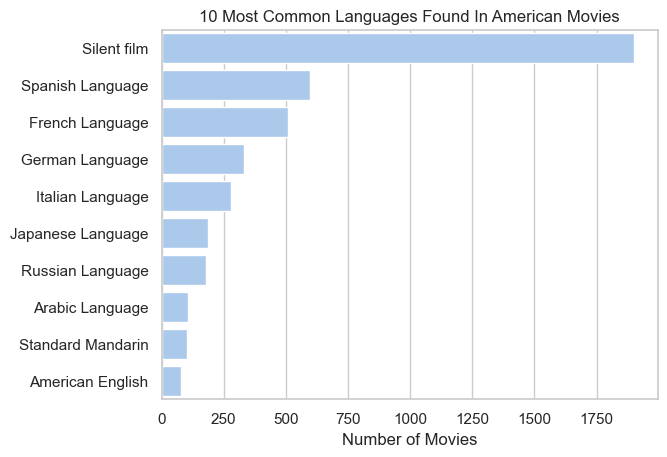

In [200]:
# create a horizontal bar graph with the most 10 common languages present in the American movies atop of English
sns.set_color_codes("pastel")
ax = sns.barplot(x="Movie_name", y="Movie_languages_clean", data = USA_lan_count[1:11], color="b")
ax.set(xlabel='Number of Movies',ylabel='',title='10 Most Common Languages Found In American Movies')

Let's analyze how the prevalence of Spanish has evolved over the years, as it may offer insights into demographic changes in the United States.

In [201]:
# filter the American movies where Spanish is present
Spanish_USA = USA_lan_explode[USA_lan_explode["Movie_languages_clean"]=="Spanish Language"]
# count the American movies with Spanish for each year
Spanish_per_year = Spanish_USA.groupby("Movie_release_year").count()["Movie_name"]
# count all American movies per year
movies_per_year = USA_df.groupby("Movie_release_year").count()["Movie_name"]
ratio = (Spanish_per_year/movies_per_year).dropna()

Text(0.5, 1.0, 'Number of Movies Presenting Spanish in The American Film Industry')

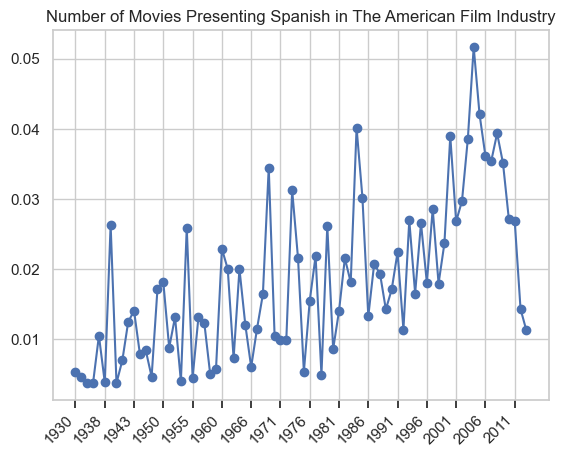

In [202]:
# plot the number of movies presenting Spanish in the American Film  Industry)
plt.plot(ratio.index,ratio.values,"-o")
plt.xticks(rotation=45, ha='right')
plt.xticks(range(0, len(ratio.index), 5))
plt.tick_params(axis='x', which='both', bottom=True,labelbottom=True)
plt.title("Number of Movies Presenting Spanish in The American Film Industry")

Despite the fluctuations, an increasing trend can be observed until 2007, aligning with the growth of the Hispanic population in the USA. It explodes around 1990 and demonstrates an exponential increase. However, there is an abrupt decrease after 2008. It can be related to the economic crisis in 2008. This might be potentially linked to the economic crisis of that year, which may have constrained the inclusion of additional languages in movies due to budgetary constraints. Also, the decrease in the number of data after 2011 could also contribute to this trend which is shown below.

In [203]:
# number of American movies between 2008 and 2013
movies_per_year['2008':'2013']

Movie_release_year
2008    940
2009    854
2010    663
2011    520
2012    350
2013     89
Name: Movie_name, dtype: int64

In [204]:
# number of all movies between 2008 and 2016
df_q3.groupby("Movie_release_year").count()["Movie_name"]['2008':'2016']

Movie_release_year
2008    2312
2009    2088
2010    1894
2011    1668
2012    1093
2013     147
2014      15
2015       4
2016       3
Name: Movie_name, dtype: int64

## Q4: Which languages are more present in a specific genre?

In this section, we aim to explore language diversity within different genres and see which languages are more present in which genres. We begin by looking at the general distribution of movies and genres in the dataset. Following that, we focus on the genre distribution in the most popular languages and, conversely, the language distribution in the most popular genres. Finally, we dig into specific genres like Martial Arts, Samurai, Romance, Gangster, War, and LGBT to see if there are any language patterns that support or challenge common stereotypes.

### Overall Language Distribution

In [205]:
df_q4 = merged_df.copy(deep=True)
# Create a dictionary to count the number of movies for each language
language_count = {}

# Iterate through the 'movie_languages_clean' column and count occurrences of each language
for languages in df_q4['Movie_languages_clean']:
    for language in languages:
        if language in language_count:
            language_count[language] += 1
        else:
            language_count[language] = 1

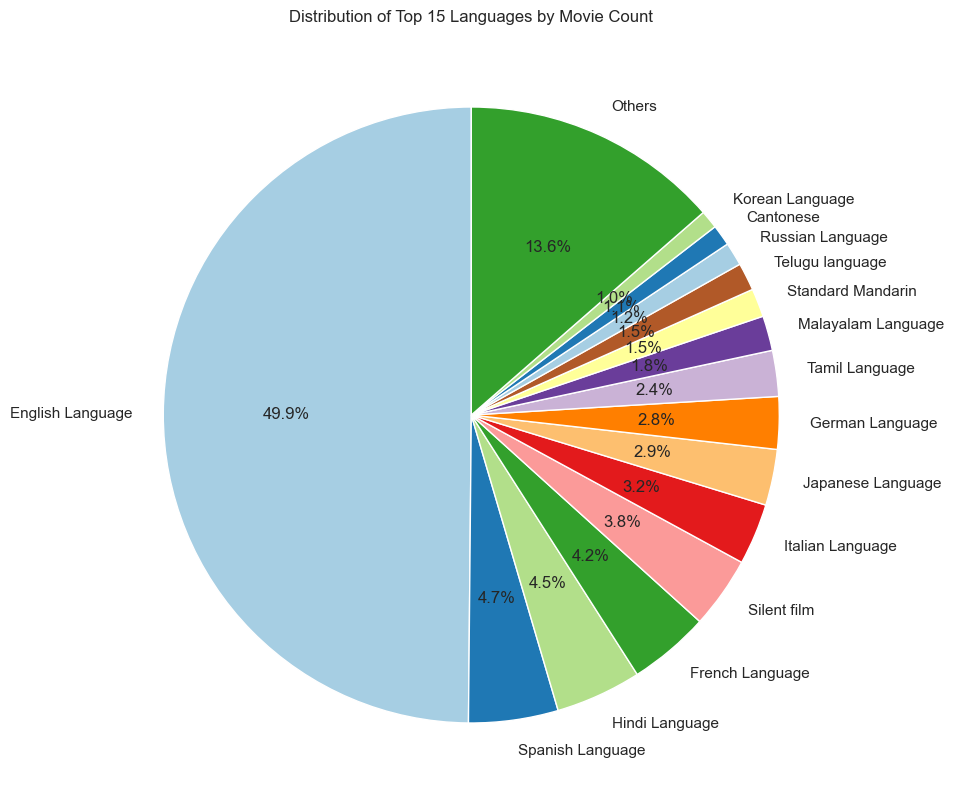

In [206]:
# Convert the dictionary to a pandas DataFrame for easy plotting
df_language_count = pd.DataFrame(list(language_count.items()), columns=['Language', 'Movie Count'])

# Sort the DataFrame by Movie Count for better visualization
df_language_count = df_language_count.sort_values(by='Movie Count', ascending=False)

# Number of top languages that will be shown in the plot
top_languages_count = 15  

# Select the top N languages
top_languages = df_language_count.head(top_languages_count)

# Create a new row for 'Others' and sum the counts
others_count = df_language_count.iloc[top_languages_count:]['Movie Count'].sum()
others_row = pd.DataFrame({'Language': ['Others'], 'Movie Count': [others_count]})

# Concatenate the top languages and 'Others'
df_language_combined = pd.concat([top_languages, others_row])

# Plotting a pie chart
plt.figure(figsize=(10, 10))
plt.pie(df_language_combined['Movie Count'], labels=df_language_combined['Language'], autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title(f'Distribution of Top {top_languages_count} Languages by Movie Count')
plt.show()

The dataset shows a significant English language presence in the movies. This is a common trend in global cinema, as English is a widely spoken and understood language. This may indicate a bias toward English-language films in the dataset. As such, we will be also looking beyond English in the further analyses of langauge distributions.

### Overall Genre Distribution

In [207]:
# genre count
genres_count = {}

for genres in df_q4['Movie_genres_clean']:
    for genre in genres:
        if genre in genres_count:
            genres_count[genre] += 1
        else:
            genres_count[genre] = 1

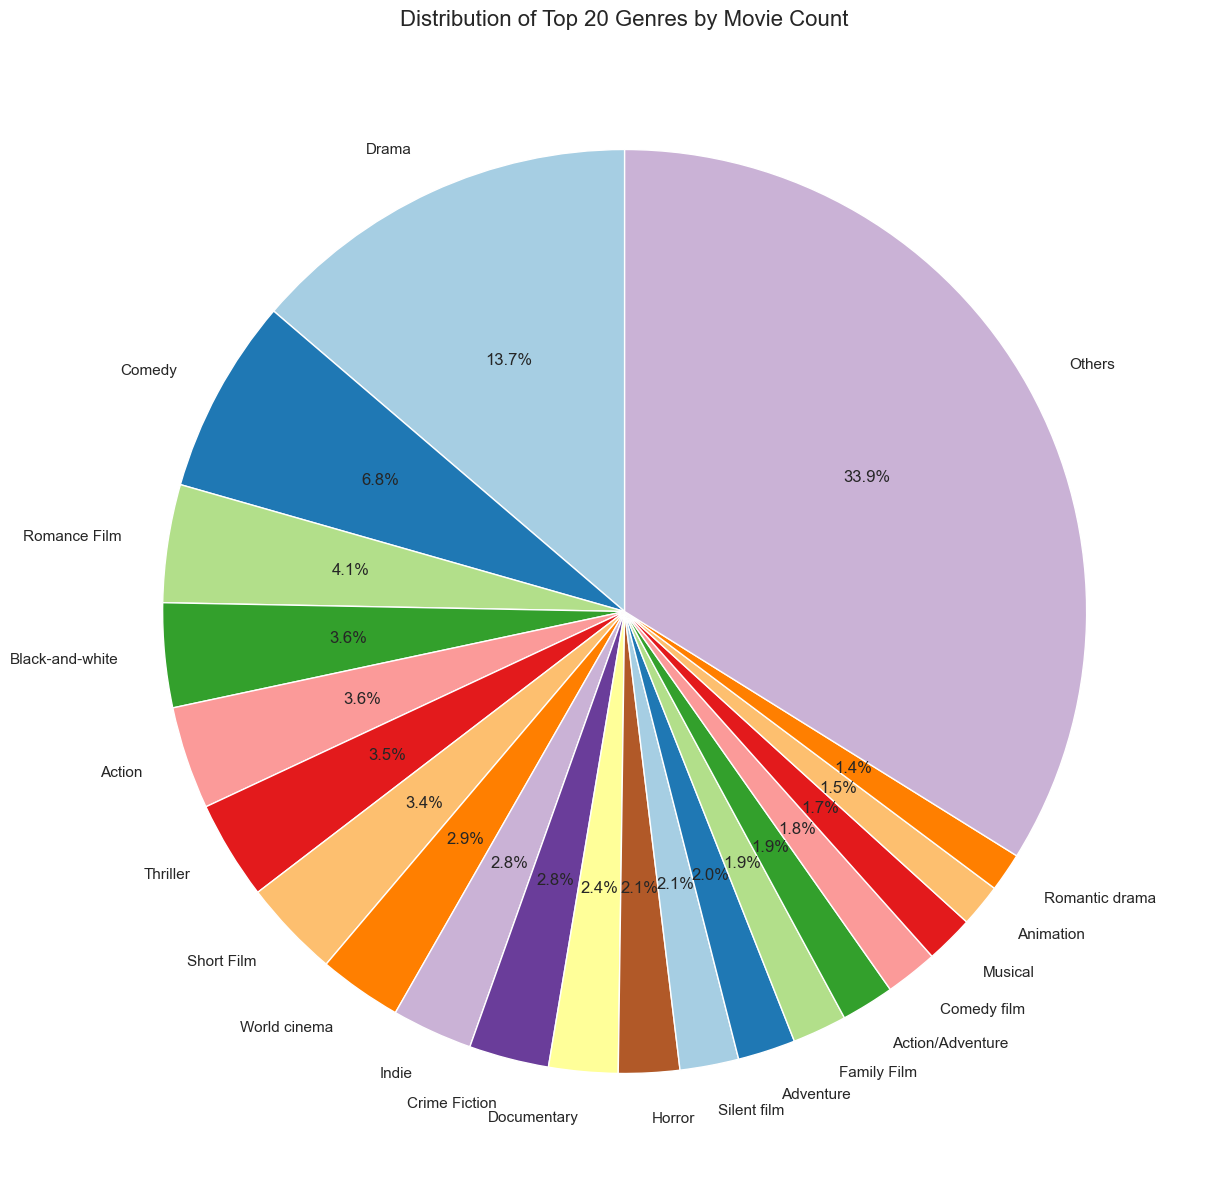

In [208]:
# Convert the dictionary to a pandas DataFrame for easy plotting
df_genres_count = pd.DataFrame(list(genres_count.items()), columns=['Genre', 'Movie Count'])

# Sort the DataFrame by Movie Count for better visualization
df_genres_count = df_genres_count.sort_values(by='Movie Count', ascending=False)

# Number of top languages that will be shown in the plot
top_genres_count = 20  

# Select the top N genres
top_genres = df_genres_count.head(top_genres_count)

# Create a new row for 'Others' and sum the counts
others_count_genres = df_genres_count.iloc[top_genres_count:]['Movie Count'].sum()
others_row_genres = pd.DataFrame({'Genre': ['Others'], 'Movie Count': [others_count_genres]})

# Concatenate the top genres and 'Others' for the pie chart
df_genres_combined = pd.concat([top_genres, others_row_genres])

# Plotting a pie chart
plt.figure(figsize=(15, 15))
plt.pie(df_genres_combined['Movie Count'], labels=df_genres_combined['Genre'], autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title(f'Distribution of Top {top_genres_count} Genres by Movie Count', fontsize=16)
plt.show()

We can observe that "Drama," "Comedy," "Thriller," and "Action" are among the most prevalent genres. This is to be expected as these genres are popular and widely produced. The dataset covers a broad range of genres, including more niche genres like "Space opera," "Film-Opera," "Ealing Comedies," and "B-movie." (They are grouped under the "Others" category in the plot)

### Genre Distribution in the Most Popular Languages

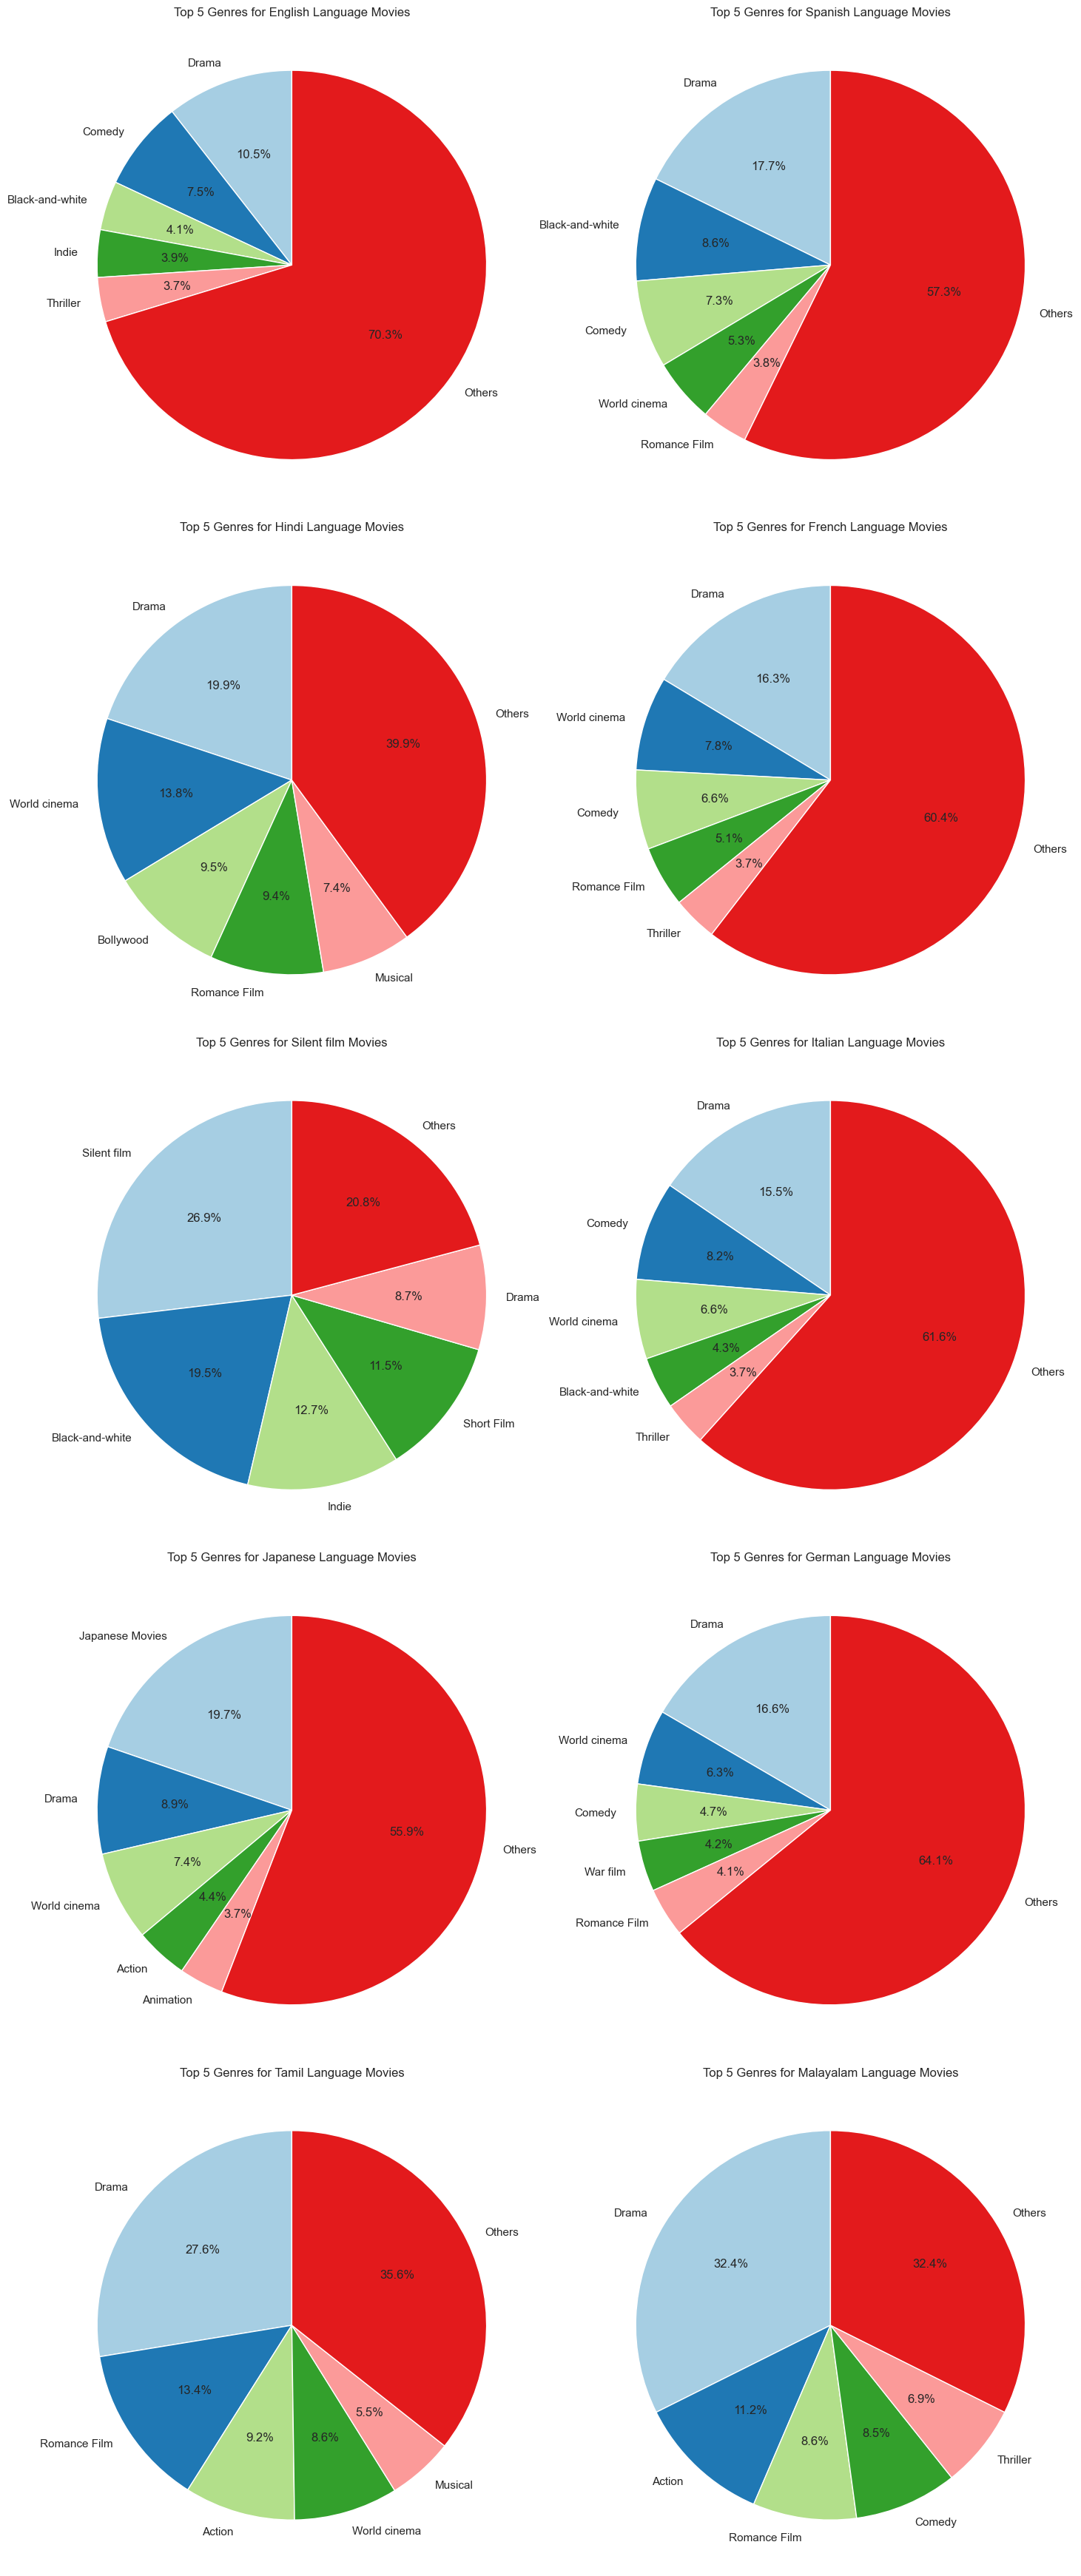

In [209]:
# Set the Seaborn style
sns.set(style="whitegrid")

# Number of languages for which we will create separate pie charts for genres
top_languages_count_genres = 10  

top_languages_genre = df_language_count.head(top_languages_count)

# Number of genres to plot for each language
top_genres_per_language = 5  

# Initialize subplots dynamically based on the number of top languages
nrows = top_languages_count_genres // 2 + top_languages_count_genres % 2  # Adjust for odd counts
fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(15, nrows * 7))
fig.subplots_adjust(wspace=0.5, hspace=0.5)

# Flatten the axes for easy indexing
axes = axes.flatten()

# Initialize a list to store DataFrames for each language
dfs_genre_breakdown = []

# Iterate over the top languages
for i, language in enumerate(top_languages_genre['Language']):
    # Filter the DataFrame for the current language
    df_language = df_q4[df_q4['Movie_languages_clean'].apply(lambda x: language in x)]
    
    # Count the genres for the current language
    genres_count_language = {}
    for genres in df_language['Movie_genres_clean']:
        for genre in genres:
            if genre in genres_count_language:
                genres_count_language[genre] += 1
            else:
                genres_count_language[genre] = 1
    
    # Convert the dictionary to a pandas DataFrame
    df_genre_count_language = pd.DataFrame(list(genres_count_language.items()), columns=['Genre', 'Movie Count'])
    
    # Select the top genres and combine the rest into 'Others'
    top_genres = df_genre_count_language.nlargest(top_genres_per_language, 'Movie Count')
    others_count = df_genre_count_language['Movie Count'].sum() - top_genres['Movie Count'].sum()
    others_row = pd.DataFrame({'Genre': ['Others'], 'Movie Count': [others_count]})
    
    # Concatenate the top genres and 'Others'
    df_genre_count_language = pd.concat([top_genres, others_row])
    
    # Add the language information
    df_genre_count_language['Language'] = language
    
    # Calculate the percentage of each genre
    df_genre_count_language['Percentage'] = (df_genre_count_language['Movie Count'] / df_genre_count_language['Movie Count'].sum()) * 100
    
    # Append the DataFrame to the list
    dfs_genre_breakdown.append(df_genre_count_language)


    # Plotting pie charts for each language
    if i < top_languages_count_genres:
        ax = axes[i]
        ax.pie(df_genre_count_language['Percentage'], labels=df_genre_count_language['Genre'], autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Paired"))
        ax.set_title(f'Top {top_genres_per_language} Genres for {language} Movies')



# Hide empty subplots
for j in range(len(top_languages_genre['Language']), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()

# Concatenate the DataFrames for all languages
df_combined_genre_breakdown = pd.concat(dfs_genre_breakdown)

# Show the plot
plt.show()

Across languages, "Drama" is consistently one of the top genres, indicating its widespread popularity and in line with its prevalence in the overall genre distribution. The global presence of World cinema across different language categories may reflect the process of globalization in the film industry. Furthermore, the strong representation of Bollywood with Hindi films reflects the dominant Indian film industry, known for its vibrant storytelling and musical elements, while the emphasis on Animation in Japanese films may reflect the country's global recognition in the form of anime.

### Language Distribution in the Most Popular Genres

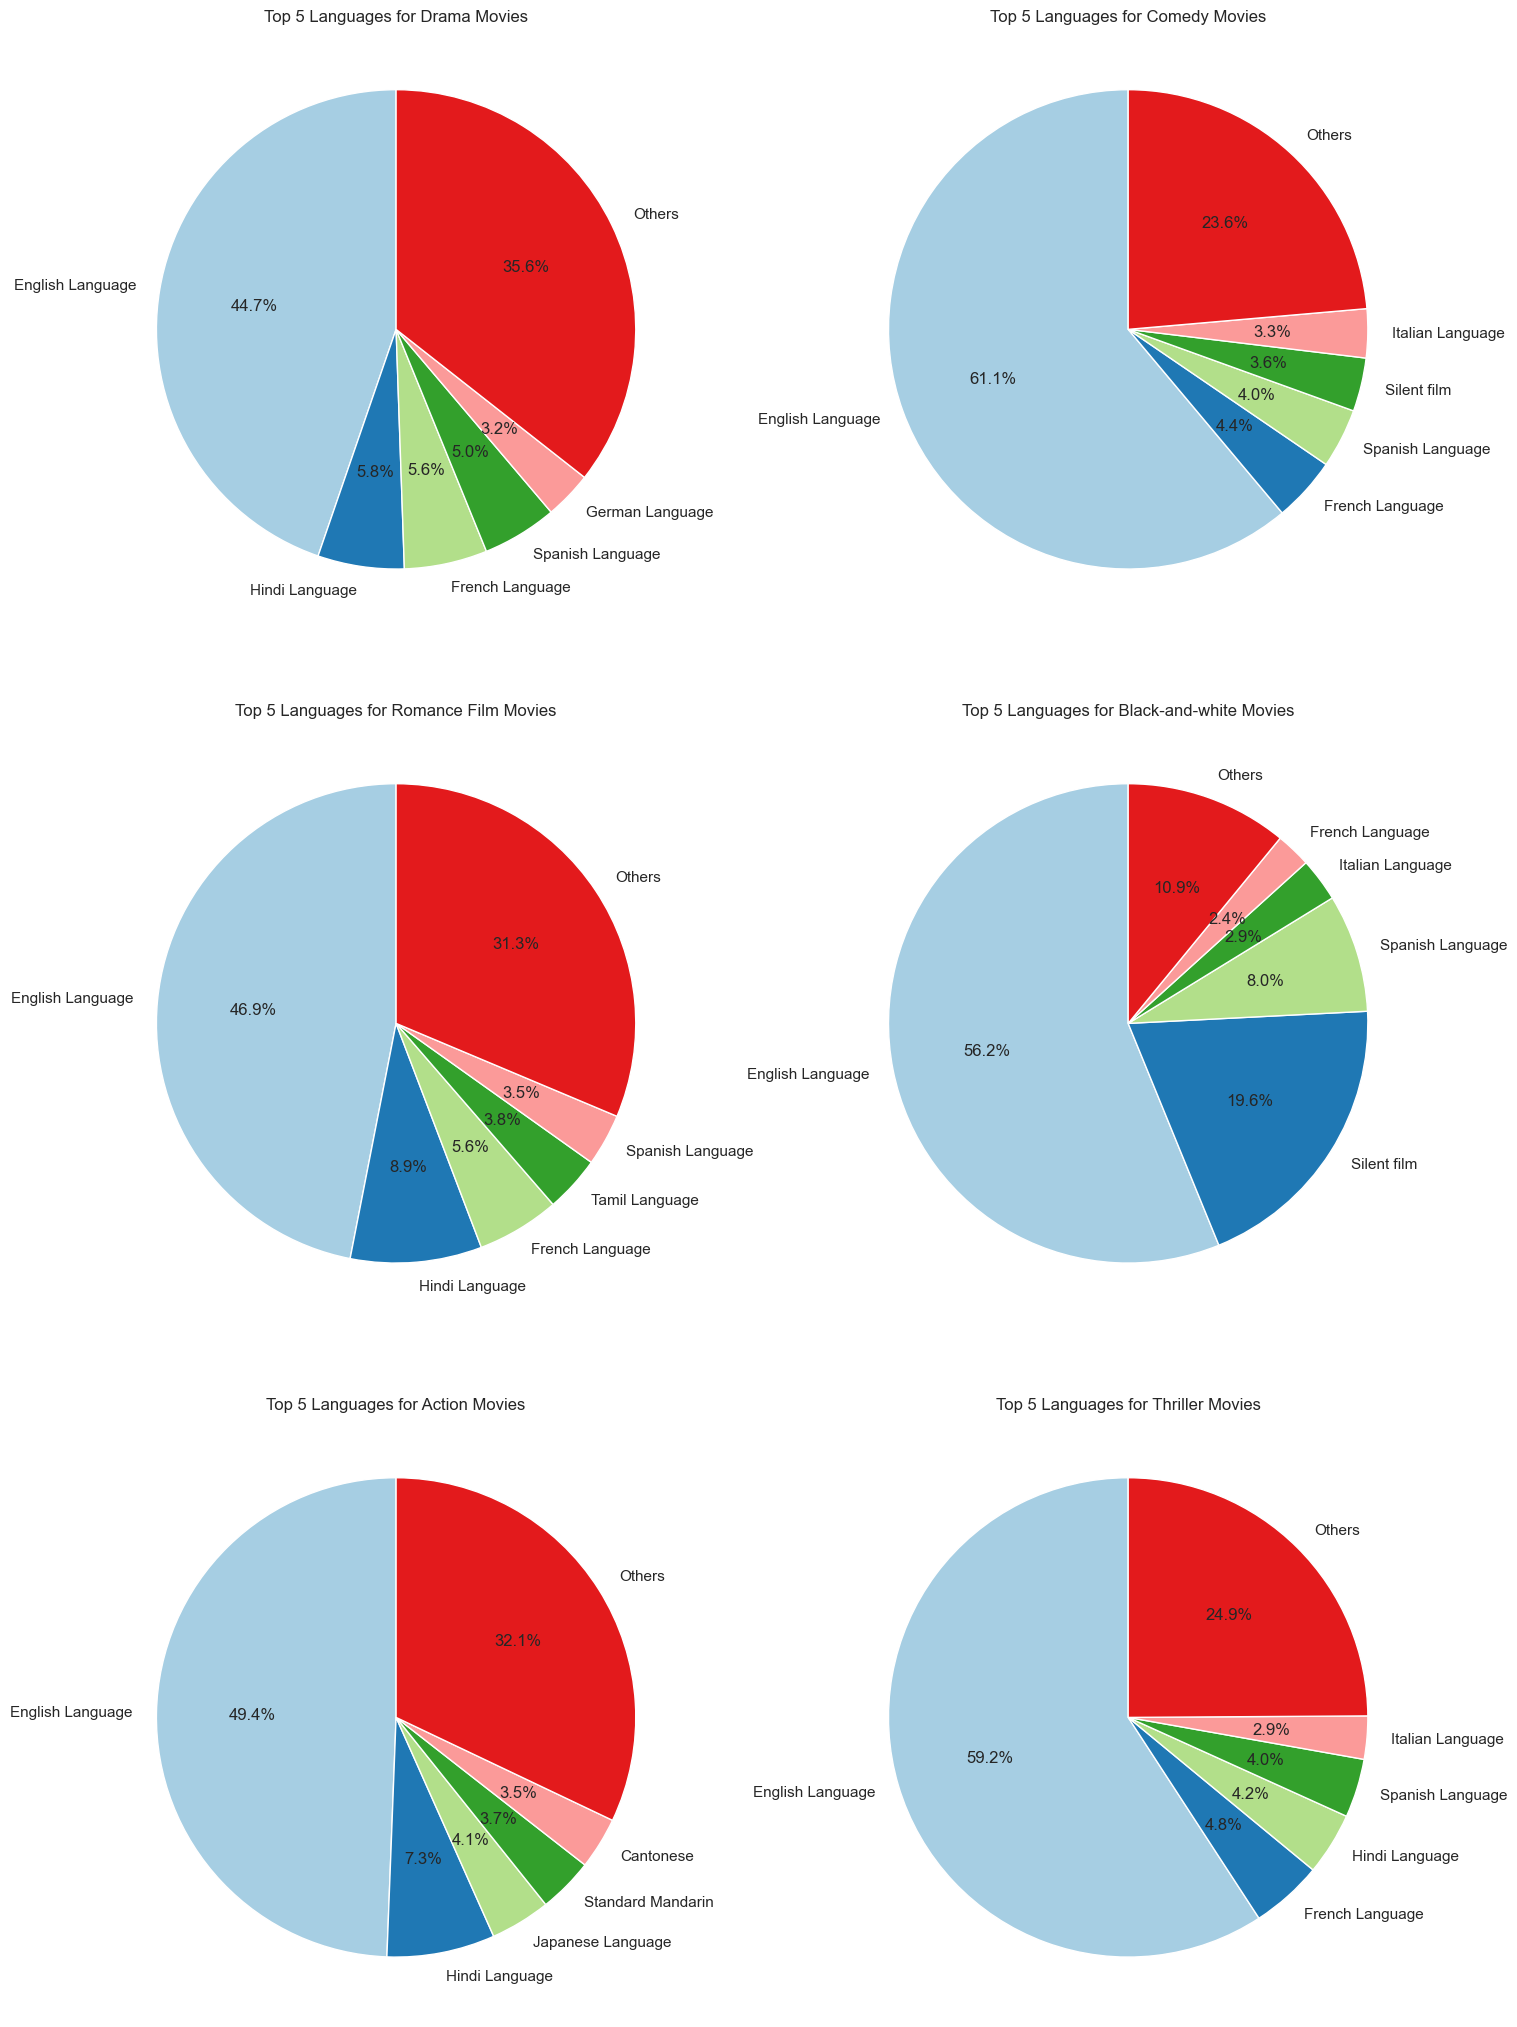

In [210]:
# Number of genres for which we will create separate pie charts for languages
top_genre_count_languages = 6  
top_genres = df_genres_count.head(top_genre_count_languages)

# Number of languages to plot for each genre
top_languages_per_genre = 5  

# Initialize subplots dynamically based on the number of top genres
nrows = top_genre_count_languages // 2 + top_genre_count_languages % 2  # Adjust for odd counts
fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(15, nrows * 7))
fig.subplots_adjust(wspace=0.5, hspace=0.5)

# Flatten the axes for easy indexing
axes = axes.flatten()

# Initialize a list to store DataFrames for each genre
dfs_language_breakdown = []

# Iterate over the top genres
for i, genre in enumerate(top_genres['Genre']):
    # Filter the DataFrame for the current genre
    df_genre = df_q4[df_q4['Movie_genres_clean'].apply(lambda x: genre in x)]
    
    # Count the languages for the current genre
    languages_count_genre = {}
    for languages in df_genre['Movie_languages_clean']:
        for language in languages:
            if language in languages_count_genre:
                languages_count_genre[language] += 1
            else:
                languages_count_genre[language] = 1
    
    # Convert the dictionary to a pandas DataFrame
    df_language_count_genre = pd.DataFrame(list(languages_count_genre.items()), columns=['Language', 'Movie Count'])
    
    # Select the top languages and combine the rest into 'Others'
    top_languages_genre = df_language_count_genre.nlargest(top_languages_per_genre, 'Movie Count')
    others_count_genre = df_language_count_genre['Movie Count'].sum() - top_languages_genre['Movie Count'].sum()
    others_row_genre = pd.DataFrame({'Language': ['Others'], 'Movie Count': [others_count_genre]})
    
    # Concatenate the top languages and 'Others'
    df_language_count_genre = pd.concat([top_languages_genre, others_row_genre])
    
    # Add the genre information
    df_language_count_genre['Genre'] = genre
    
    # Append the DataFrame to the list
    dfs_language_breakdown.append(df_language_count_genre)
    
    # Plotting pie charts for each genre
    if i < top_genre_count_languages:
        ax = axes[i]
        ax.pie(df_language_count_genre['Movie Count'], labels=df_language_count_genre['Language'], autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Paired"))
        ax.set_title(f'Top {top_languages_per_genre} Languages for {genre} Movies')


# Hide empty subplots
for j in range(len(top_genres['Genre']), len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout()
plt.show()


English stands out as the dominant language in all genres, which is expected given its widespread use and the substantial presence of English-language movies in the dataset. This suggests that one must look beyond english to gain deeper insights. Exploring the languages within a given genre beyond English could reveal more nuanced trends and associations between languages and genres. The strong representation of silent films within the black-and-white genre, less pronounced in other genre breakdowns, can be attributed to the historical reason as during the early years of cinema, many films were produced without sound and in black and white.

### Language Distribution in Some Specific Genres

#### Martial Arts

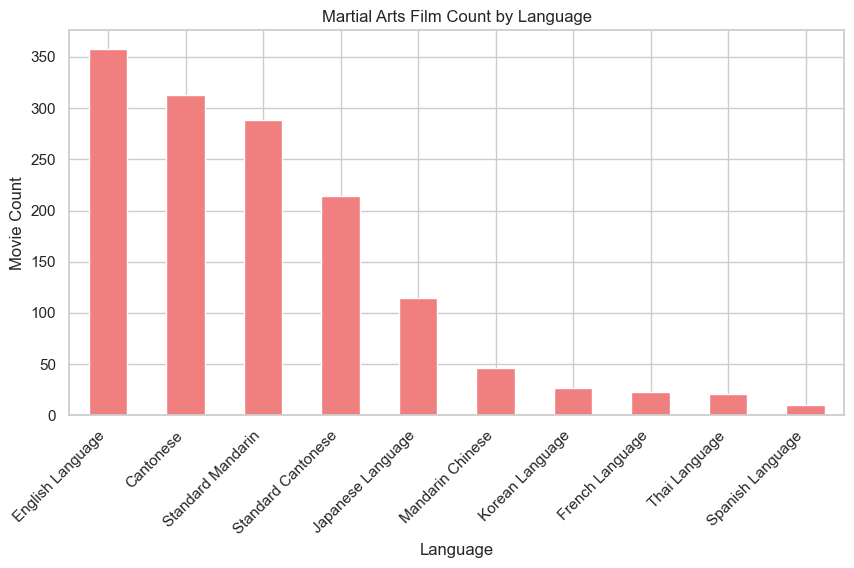

In [211]:
# Count Martial Arts Film by Language
martial_arts_count = df_q4[df_q4['Movie_genres_clean'].apply(lambda x: 'Martial Arts Film' in x)]['Movie_languages_clean'].explode().value_counts()

# Number of languages that will be represented in the plot
threshold = 10  

# Filter languages based on the threshold
top_languages_martial = martial_arts_count.head(threshold)

# Plot the bar chart
plt.figure(figsize=(10, 5))
top_languages_martial.plot(kind='bar', color='lightcoral')
plt.title('Martial Arts Film Count by Language')
plt.xlabel('Language')
plt.ylabel('Movie Count')
plt.xticks(rotation=45, ha='right')
plt.show()

While English-language martial arts films outnumber those in other languages, the genre also demonstrates strong representation of East Asian languages such as Cantonese, Standard Mandarin and Japanese. The dataset's dominance by English-language films may skew the overall counts, but the substantial presence of Asian languages reaffirms the genre's profound connection to East Asian cultures.

#### Samurai

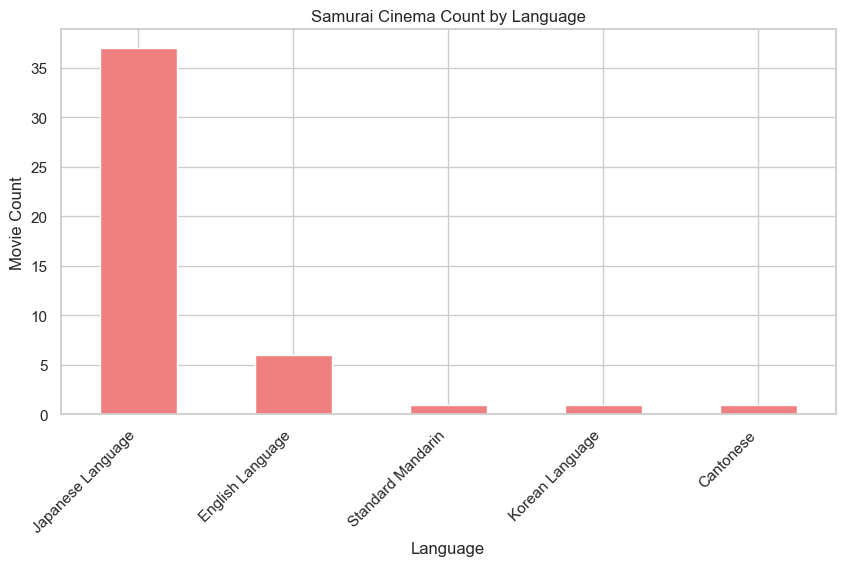

In [212]:
# Count Samurai cinema by Language
samurai_count = df_q4[df_q4['Movie_genres_clean'].apply(lambda x: 'Samurai cinema' in x)]['Movie_languages_clean'].explode().value_counts()

# Number of languages to be represented in the plot
threshold = 10  

# Filter languages based on the threshold
top_languages_samurai = samurai_count.head(threshold)

# Plot the bar chart
plt.figure(figsize=(10, 5))
top_languages_samurai.plot(kind='bar', color='lightcoral')
plt.title('Samurai Cinema Count by Language')
plt.xlabel('Language')
plt.ylabel('Movie Count')
plt.xticks(rotation=45, ha='right')
plt.show()

The data indicates that the presence of Japanese language is predominant in the "Samurai cinema" genre, aligning with the expectation that this genre is a significant part of Japan's cinematic heritage. The majority of occurrences (37 out of 46) are in the Japanese language, emphasizing the cultural specificity of the genre.

#### War

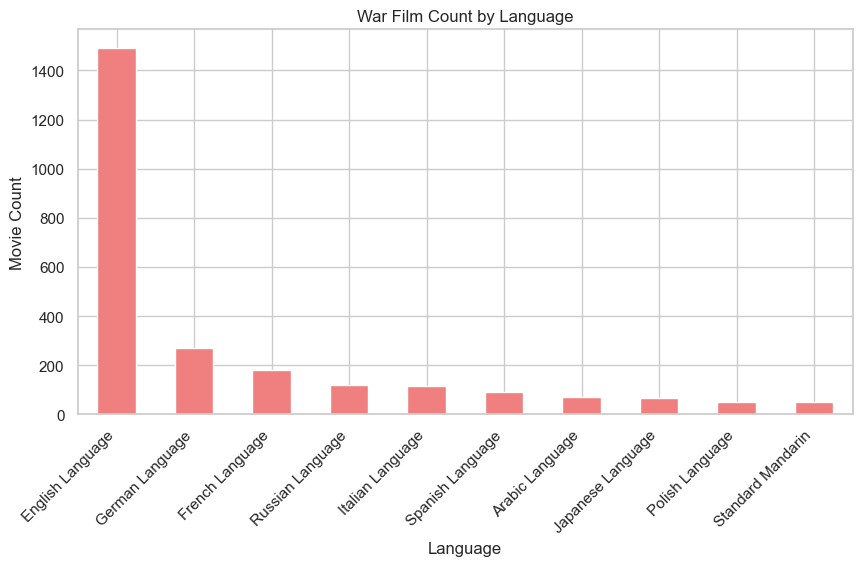

In [213]:
# Count War films by Language
war_film_by_language = df_q4[df_q4['Movie_genres_clean'].apply(lambda x: 'War film' in x)]['Movie_languages_clean'].explode().value_counts()

# Number of languages to be represented in the plot
threshold = 10  

# Filter languages based on the threshold
top_languages_war = war_film_by_language.head(threshold)

# Plot the bar chart 
plt.figure(figsize=(10, 5))
top_languages_war.plot(kind='bar', color='lightcoral')
plt.title('War Film Count by Language')
plt.xlabel('Language')
plt.ylabel('Movie Count')
plt.xticks(rotation=45, ha='right')

plt.show()

An interesting observation here is the lower presence of languages like Hindi and Tamil in the 'War film' genre, despite their higher representation in general movie counts. This could be due to regional preferences, especially in India, where war films may not be as favored as other genres. On the other hand, the notable increase in popularity of German language movies in this genre stands out, given its humble scale in the overall language distribution.

#### Romance

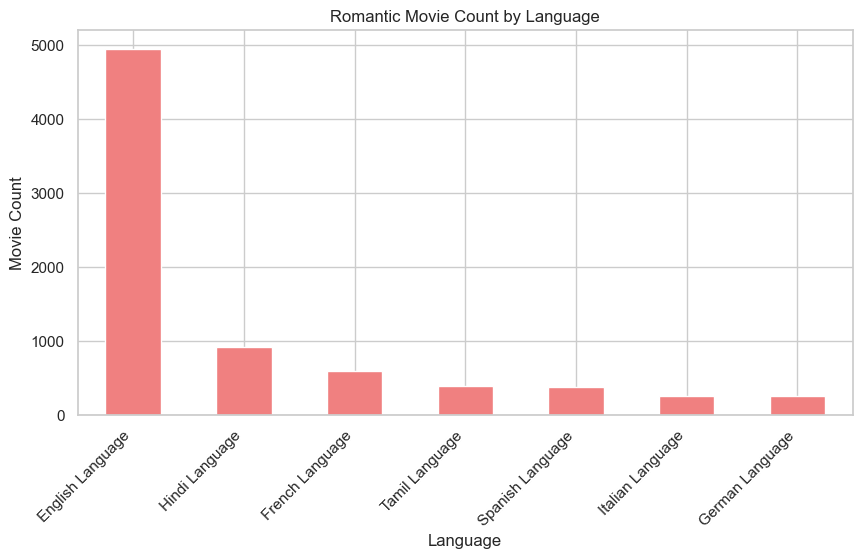

In [214]:
# Count Romantic movies by Language
romantic_languages = df_q4[df_q4['Movie_genres_clean'].apply(lambda x: 'Romance Film' in x or 'Romantic drama' in x)]['Movie_languages_clean'].explode().value_counts()

# Number of languages to be represented in the plot
threshold = 7  

# Filter languages based on the threshold
top_languages_romantic = romantic_languages.head(threshold)

plt.figure(figsize=(10, 5))
top_languages_romantic.plot(kind='bar', color='lightcoral')
plt.title('Romantic Movie Count by Language')
plt.xlabel('Language')
plt.ylabel('Movie Count')
plt.xticks(rotation=45, ha='right')

plt.show()

The language distribution in this genre resembles the global representation across all genres, emphasizing English dominance and higher counts for Hindi, Tamil, Spanish, and French, in alignment with the overall language breakdown.

#### Gangster

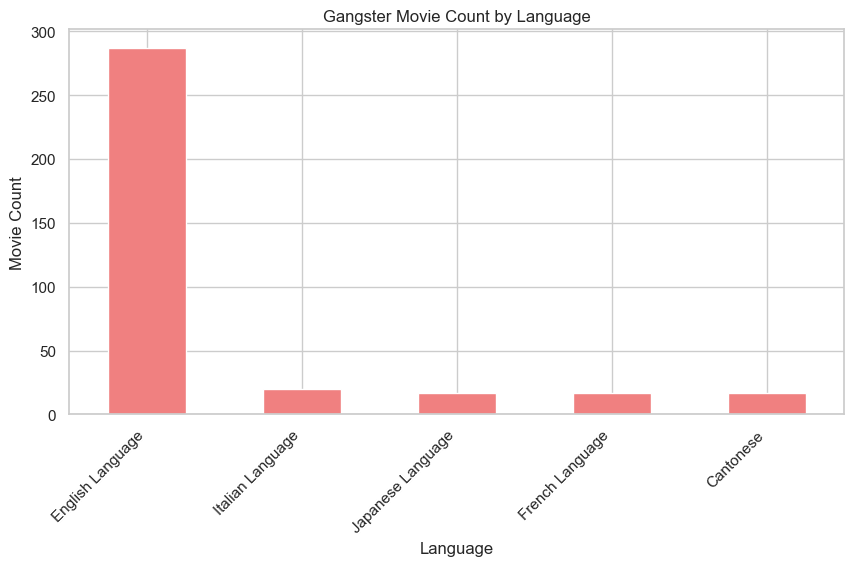

In [215]:
# Count Gangster movies by Language
gangster_language_diversity = df_q4[df_q4['Movie_genres_clean'].apply(lambda x: 'Gangster Film' in x)]['Movie_languages_clean'].explode().value_counts()

# Number of languages to be represented in the plot
threshold = 5  

# Filter languages based on the threshold
top_languages_gangster = gangster_language_diversity.head(threshold)

# Plot the bar chart 
plt.figure(figsize=(10, 5))
top_languages_gangster.plot(kind='bar', color='lightcoral')
plt.title('Gangster Movie Count by Language')
plt.xlabel('Language')
plt.ylabel('Movie Count')
plt.xticks(rotation=45, ha='right')

plt.show()

Looking at the data, we can observe certain stereotypical associations between Japan and gangsters, as well as Italy and gangsters, that seem to be reflected and captured in cinema. In Japanese cinema, gangster portrayals often revolve around the Yakuza, a notorious organized crime syndicate that frequently appears in Japanese gangster films Similarly, Italian cinema, especially in Hollywood, is often associated with Mafia depictions. The American Mafia, rooted in Italian organized crime, prominently features in gangster films, as seen in classics like "The Godfather" trilogy, portraying the Italian-American Mafia.

#### LGBT

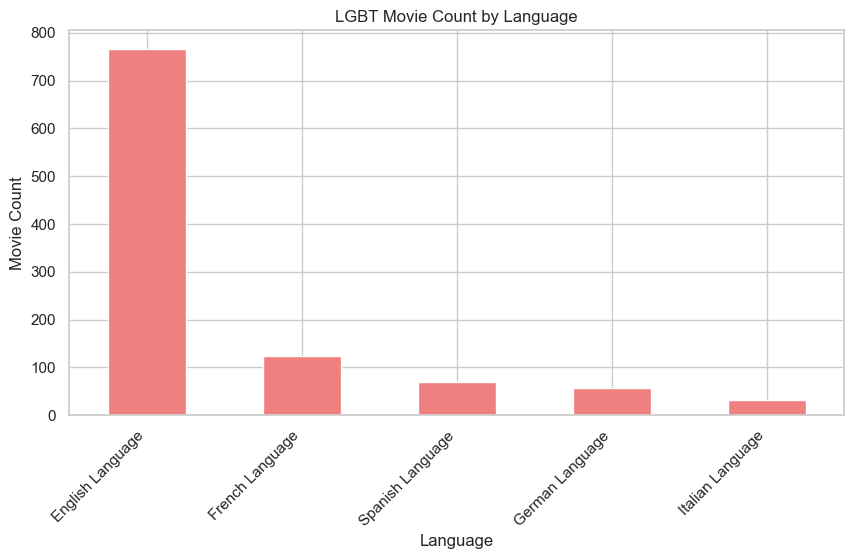

In [216]:
# Count LGBT-themed movies by Language
lgbt_language_diversity = df_q4[df_q4['Movie_genres_clean'].apply(lambda x: 'LGBT' in x or 'Gay Interest' in x or 'Gay Themed' in x)]['Movie_languages_clean'].explode().value_counts()

# Number of languages to be represented in the plot
threshold = 5  

# Filter languages based on the threshold
top_languages_lgbt = lgbt_language_diversity.head(threshold)

# Plot the bar chart
plt.figure(figsize=(10, 5))
top_languages_lgbt.plot(kind='bar', color='lightcoral')
plt.title('LGBT Movie Count by Language')
plt.xlabel('Language')
plt.ylabel('Movie Count')
plt.xticks(rotation=45, ha='right')
plt.show()


The non-presence of Hindi and Tamil languages, otherwise very much present in the general language distribution, may suggest the non-penetrance of LGBTQ themes or a lack of societal acceptance of such themes in India and other comparable developing countries.